# Environments

# Eval

In [2]:
"""
In this demo, we evaluate the performance of the
lofi bandit on a tabular dataset
"""
import os
import re
import jax
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import flax.linen as nn
from datetime import datetime
import matplotlib.pyplot as plt
from bayes_opt import BayesianOptimization

from bandits import training as btrain
from bandits.agents.linear_bandit import LinearBandit
from bandits.agents.low_rank_filter_bandit import LowRankFilterBandit
from bandits.agents.neural_linear import NeuralLinearBandit
from bandits.agents.neural_greedy import NeuralGreedyBandit
from bandits.environments.mnist_env import MnistEnvironment

import lofi_tabular as experiment

In [359]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"
plt.rcParams["font.size"] = 14

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [395]:
ntrials = 1
npulls = 20
key = jax.random.PRNGKey(314)
key_env, key_train, key_eval = jax.random.split(key, 3)

# env = TabularEnvironment(key_env, ntrain=ntrain, name='statlog', intercept=False, path="../bandit-data")
env = MnistEnvironment(key, ntrain=500)
env_test = MnistEnvironment(key, ntrain=25_000)

num_arms = env.labels_onehot.shape[-1]

In [424]:
class MLP(nn.Module):
    num_arms: int

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(500)(x)
        x = nn.elu(x)
        x = nn.Dense(500)(x)
        x = nn.elu(x)
        x = nn.Dense(500, name="last_layer")(x)
        x = nn.elu(x)
        x = nn.Dense(self.num_arms)(x)
        return x
model = MLP(num_arms)

In [425]:
optimisers = {}
results = {}

## LoFi: Fixed dynamics

Setting $\gamma=1.0$, $q = 0.0$.

In [426]:
name_agent = "lofi-fixed"
extra_params = {
    "memory_size": 15,
    "model": model,
    "dynamics_weights": 1.0,
    "dynamics_covariance": 0.0,

}

@jax.jit
def bbf(**heval):
    res = experiment.warmup_and_run(
        heval, 
        experiment.transform_hparams_lofi_fixed,
        LowRankFilterBandit,
        env,
        key_train,
        npulls,
        **extra_params,
    )

    
    return res["hist_train"]["rewards"].sum()

In [427]:
%%time
# try q=0, γ=1
pbounds = {
    "log_em_cov": [-10, 0], # empirical covariance
    "log_init_cov": [-10, 0],
}


optimiser = BayesianOptimization(
    f=bbf,
    pbounds=pbounds,
    random_state=2718,
)

# LoFi
optimiser.maximize(init_points=5, n_iter=15)

|   iter    |  target   | log_em... | log_in... |
-------------------------------------------------
| 1         | 53.0      | -5.738    | -2.971    |
| 2         | 59.0      | -1.514    | -9.956    |
| 3         | 208.0     | -9.159    | -9.927    |
| 4         | 62.0      | -4.961    | -5.19     |
| 5         | 51.0      | -1.243    | -1.285    |
| 6         | 182.0     | -9.99     | -7.321    |
| 7         | 206.0     | -10.0     | -10.0     |
| 8         | 208.0     | -7.342    | -10.0     |
| 9         | 46.0      | -10.0     | 0.0       |
| 10        | 202.0     | -8.071    | -9.023    |
| 11        | 215.0     | -8.138    | -10.0     |
| 12        | 215.0     | -8.253    | -10.0     |
| 13        | 215.0     | -8.124    | -9.937    |
| 14        | 222.0     | -10.0     | -8.94     |
| 15        | 220.0     | -10.0     | -8.578    |
| 16        | 222.0     | -9.648    | -8.876    |
| 17        | 185.0     | -9.261    | -9.012    |
| 18        | 208.0     | -6.085    | -8.4      |


In [ ]:
%%time
res = experiment.warmup_and_run(
    optimiser.max["params"], 
    experiment.transform_hparams_lofi_fixed,
    LowRankFilterBandit,
    env_test,
    key_eval,
    npulls,
    n_trials=8,
    **extra_params,
)

res = jax.tree_map(np.array, res)
results[name_agent] = res
optimisers[name_agent] = optimiser

## Linear

## Neural linear

In [ ]:
name_agent = "neural-linear"
extra_params = {
    "model": model,
    "update_step_mod": 100,
    "nepochs": 100,
    "batch_size": 1000,

}


extra_params = {
    "model": model,
    "update_step_mod": 1,
    "nepochs": 1,
    "batch_size": 1,

}


@jax.jit
def bbf(**heval):
    res = experiment.warmup_and_run(
        heval, 
        experiment.transform_hparams_neural_linear,
        NeuralLinearBandit,
        env,
        key_train,
        npulls,
        **extra_params
    )
    
    return res["hist_train"]["rewards"].sum()

In [ ]:
%%time
pbounds = {
    "eta": [0, 10],
    "log_lambda": [-15, 0], # -15, 0 
    "log_lr": [-10, -2]
}


optimiser = BayesianOptimization(
    f=bbf,
    pbounds=pbounds,
    random_state=2718,
)
# Neural linear
optimiser.maximize(init_points=5, n_iter=15)

In [ ]:
%%time
res = experiment.warmup_and_run(
    optimiser.max["params"], 
    experiment.transform_hparams_neural_linear,
    NeuralLinearBandit,
    env_test,
    key_eval,
    npulls,
    n_trials=8,
    **extra_params
)

results[name_agent] = res
optimisers[name_agent] = optimiser

## Neural Greedy (replay-buffer)

In [ ]:
name_agent = "rsgd"
extra_params = {
    "model": model,
    "memory_size": 1,
    "epsilon": 0.01,
    "n_inner": 1.0,

}

@jax.jit
def bbf(**heval):
    res = experiment.warmup_and_run(
        heval, 
        experiment.transform_hparams_rsgd,
        NeuralGreedyBandit,
        env,
        key_train,
        npulls,
        **extra_params
    )
    
    return res["hist_train"]["rewards"].sum()

In [ ]:
%%time
pbounds = {
    "log_lr": [-10, -2]
}


optimiser = BayesianOptimization(
    f=bbf,
    pbounds=pbounds,
    random_state=2718,
)

optimiser.maximize(init_points=5, n_iter=15)

In [ ]:
%%time
res = experiment.warmup_and_run(
    optimiser.max["params"], 
    experiment.transform_hparams_rsgd,
    NeuralGreedyBandit,
    env_test,
    key_eval,
    npulls,
    n_trials=8,
    **extra_params
)

results[name_agent] = res
optimisers[name_agent] = optimiser

## Plots

In [442]:
results.keys()

dict_keys(['lofi-fixed', 'neural-linear', 'rsgd'])

In [443]:
name_mapping = {
    "lofi-fixed": "Neural-Lofi TS",
    "linear": "Linear TS",
    "neural-linear": "Neural-linear TS",
    "rsgd": "OGD Greedy",
}

In [444]:
filename = "bandit-showdown-mem10.pkl"
path = os.path.join("output", "results", filename)

with open(path, "wb") as f:
    pickle.dump(results, f)

lofi-fixed - 20058.62±914.97
neural-linear - 10535.88±2862.72
rsgd - 20185.00±135.81


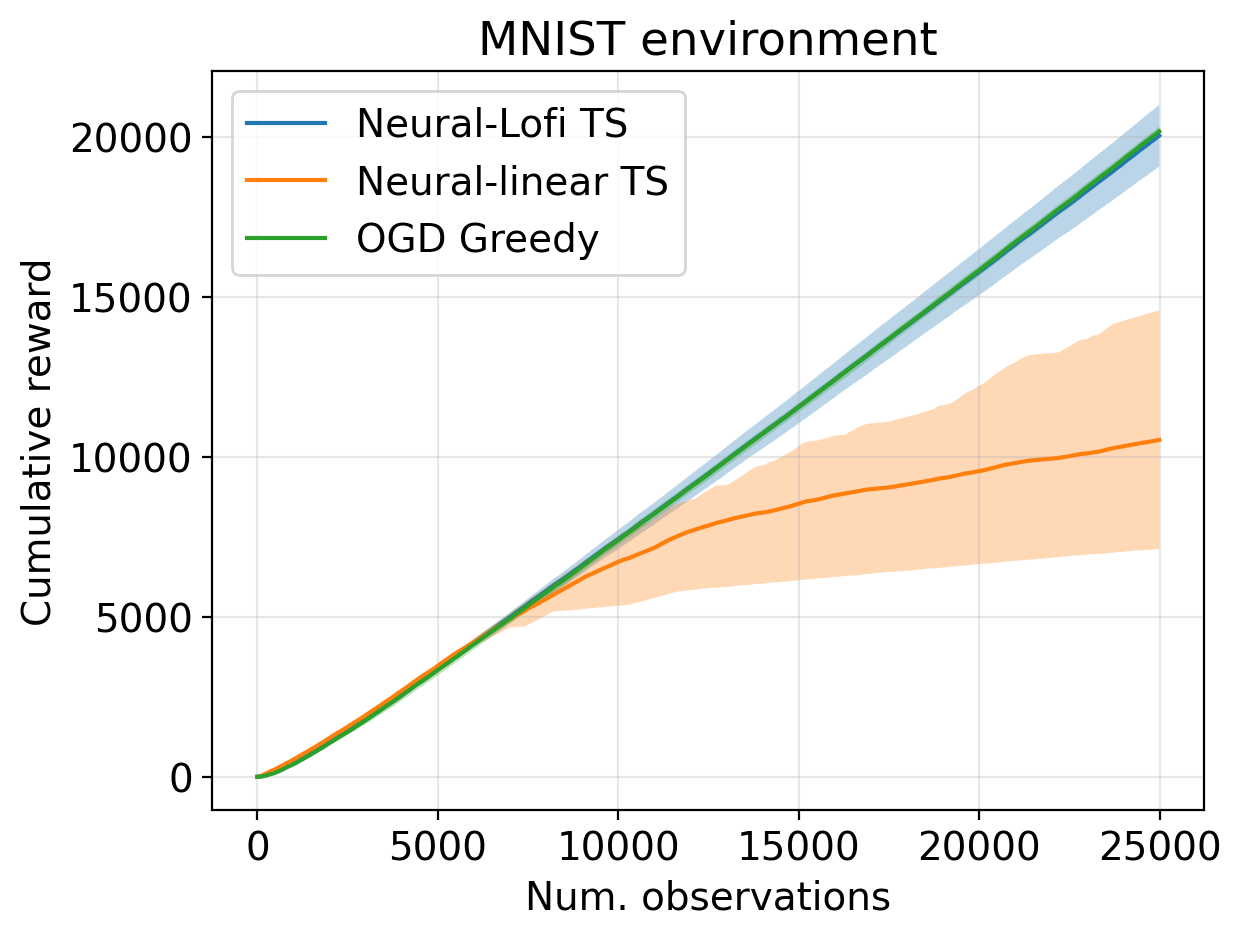

In [451]:
for name, res in results.items():
    label = name_mapping[name]
    rewards = res["hist_train"]["rewards"]
    mean_reward = rewards.sum(axis=1).mean()
    std_reward = rewards.sum(axis=1).std()

    rewards = pd.DataFrame(rewards).T.cumsum(axis=0)
    # rewards = rewards.apply(lambda x: np.arange(len(x)) - x)
    print(f"{name} - {mean_reward:0.2f}±{std_reward:0.2f}")

    nsteps = len(rewards)
    rmean = rewards.mean(axis=1)
    ubound = rewards.quantile(0.9, axis=1)
    lbound = rewards.quantile(0.1, axis=1)
    
    plt.fill_between(rewards.index, lbound, ubound, alpha=0.3)
    plt.plot(rewards.index, rmean, label=label)
    
# plt.plot([0, nsteps], [0, nsteps], c="tab:gray", linewidth=1, linestyle="--", label="oracle")
plt.legend()
plt.grid(alpha=0.3)
plt.ylabel("Cumulative reward")
plt.xlabel("Num. observations")
plt.title("MNIST environment")
plt.savefig("./output/figures/mnist-bandits-regret.pdf")

In [446]:
from rebayes.utils.utils import get_subtree

In [447]:
rewards_all = get_subtree(results, "hist_train")
rewards_all = get_subtree(rewards_all, "rewards")
rewards_all = jax.tree_map(lambda x: np.sum(x, axis=1), rewards_all)
rewards_all = pd.DataFrame(rewards_all)

rewards_all.mean(axis=0)

lofi-fixed       20058.625
neural-linear    10535.875
rsgd             20185.000
dtype: float32

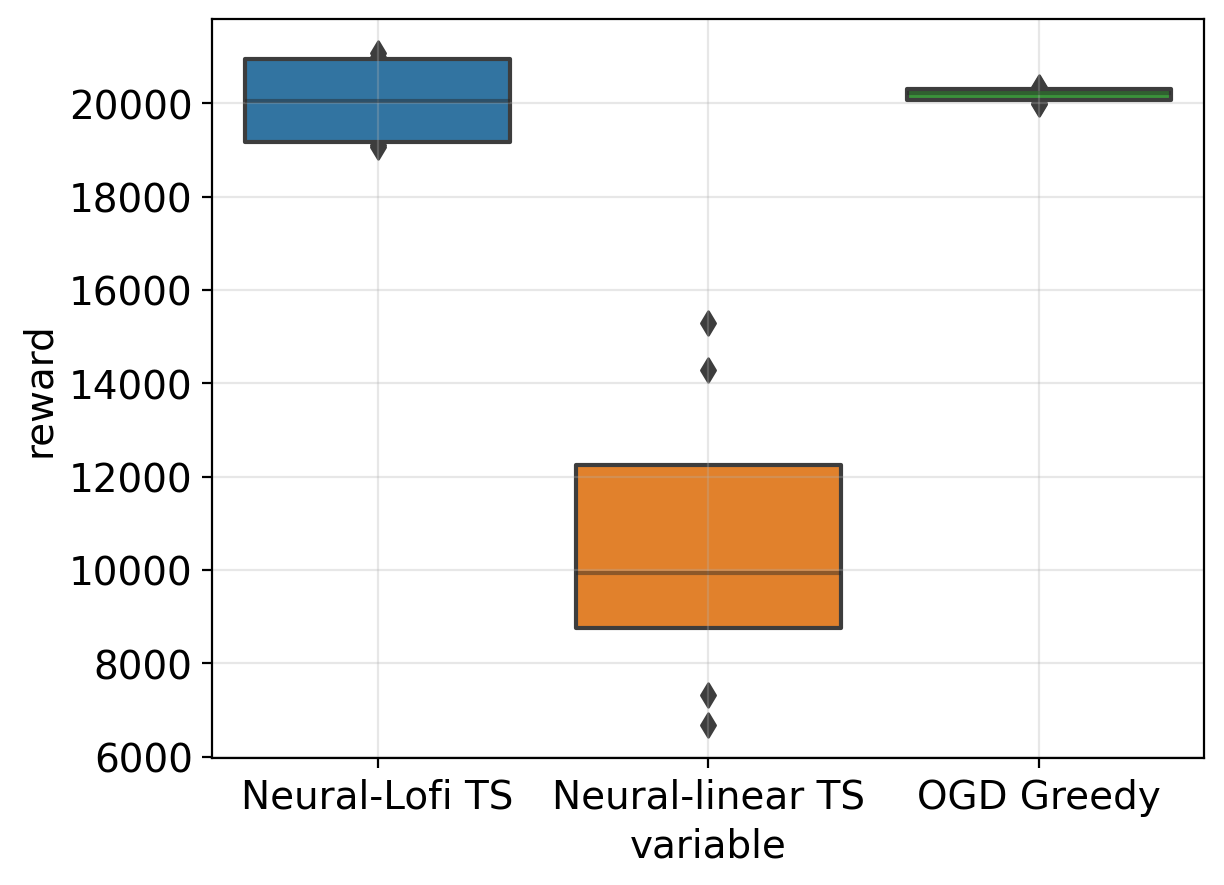

In [448]:
sns.boxenplot(
    x="variable",
    y="reward",
    data=(
        rewards_all
        .rename(name_mapping, axis=1)
        .melt(value_name="reward")
        .query("variable != 'linear'")
    )
)
plt.grid(alpha=0.3)
plt.savefig("./output/figures/mnist-bandits-final-reward.pdf")